
              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 28 2023 11:53:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



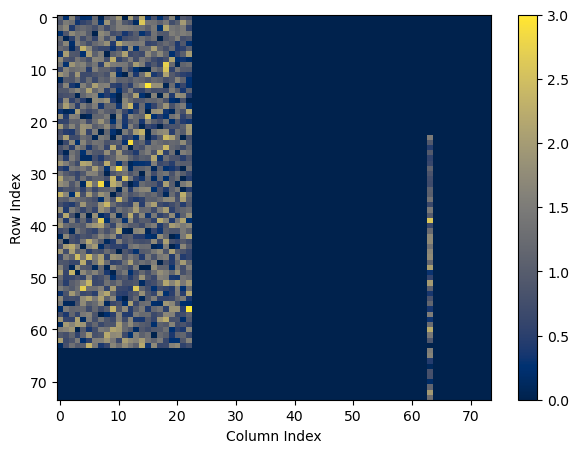


Apr 09 17:14:05 NodeManager::prepare_nodes [Info]: 
    Preparing 81 nodes for simulation.

Apr 09 17:14:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 81
    Simulation time (ms): 2501
    Number of OpenMP threads: 1
    Not using MPI

Apr 09 17:14:05 SimulationManager::run [Info]: 
    Simulation finished.


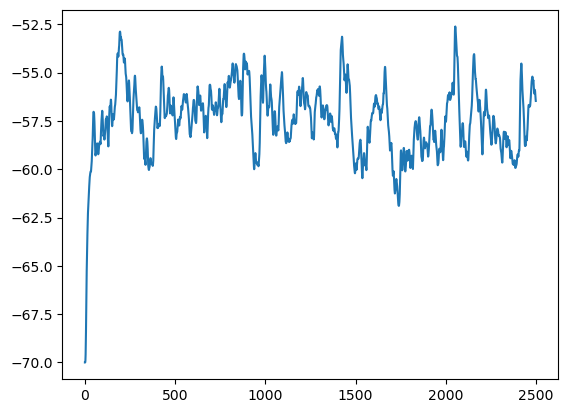

In [1]:
import pandas as pd
import numpy as np
from scripts import neuron_categorization, optimization, model, visualizations, preprocessing
import matplotlib.pyplot as plt

spike_trains = np.load('/hpc/mzhu843/modelling/nest/DATA/processed/spikes/S_3_p.npy')[:,:2500]
calcium_traces = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')[:,:2500]
ez_track_data = pd.read_csv('/hpc/mzhu843/modelling/nest/DATA/raw/ezytrack/behaviour_LocationOutput.csv', nrows=2500)

categorizer = neuron_categorization.NeuronCategorizer(spike_trains, calcium_traces, ez_track_data)
categorizer.run_categorization()

weights = np.load('/hpc/mzhu843/modelling/nest/DATA/processed/optimised_matrix/optimised_weights.npy')
visualizations.plot_matrix(weights)

model = model.NeuronalNetwork(weights, categorizer.get_categorized_neurons(), runtime=2501)

model.simulate()

voltages_trace_pyr = model.voltage_traces_pyr



ts = range(len(voltages_trace_pyr[2]))
i=1
for trace in voltages_trace_pyr:
    plt.plot(ts, trace)
    plt.savefig('/hpc/mzhu843/modelling/nest/plots/temp results/Neuron ' + str(i))
    plt.close()
    i += 1




plt.plot(ts, voltages_trace_pyr[2])
plt.show()










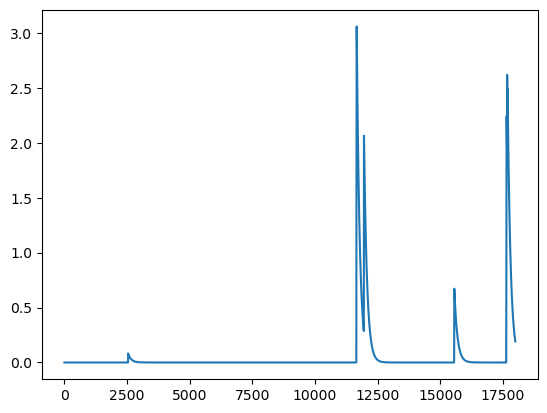

In [2]:
import numpy as np
import matplotlib.pyplot as plt

calcium = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')
plt.plot(calcium[0])


Apr 09 17:14:09 NodeManager::prepare_nodes [Info]: 
    Preparing 95 nodes for simulation.

Apr 09 17:14:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 95
    Simulation time (ms): 17988
    Number of OpenMP threads: 1
    Not using MPI

Apr 09 17:14:09 SimulationManager::run [Info]: 
    Simulation finished.


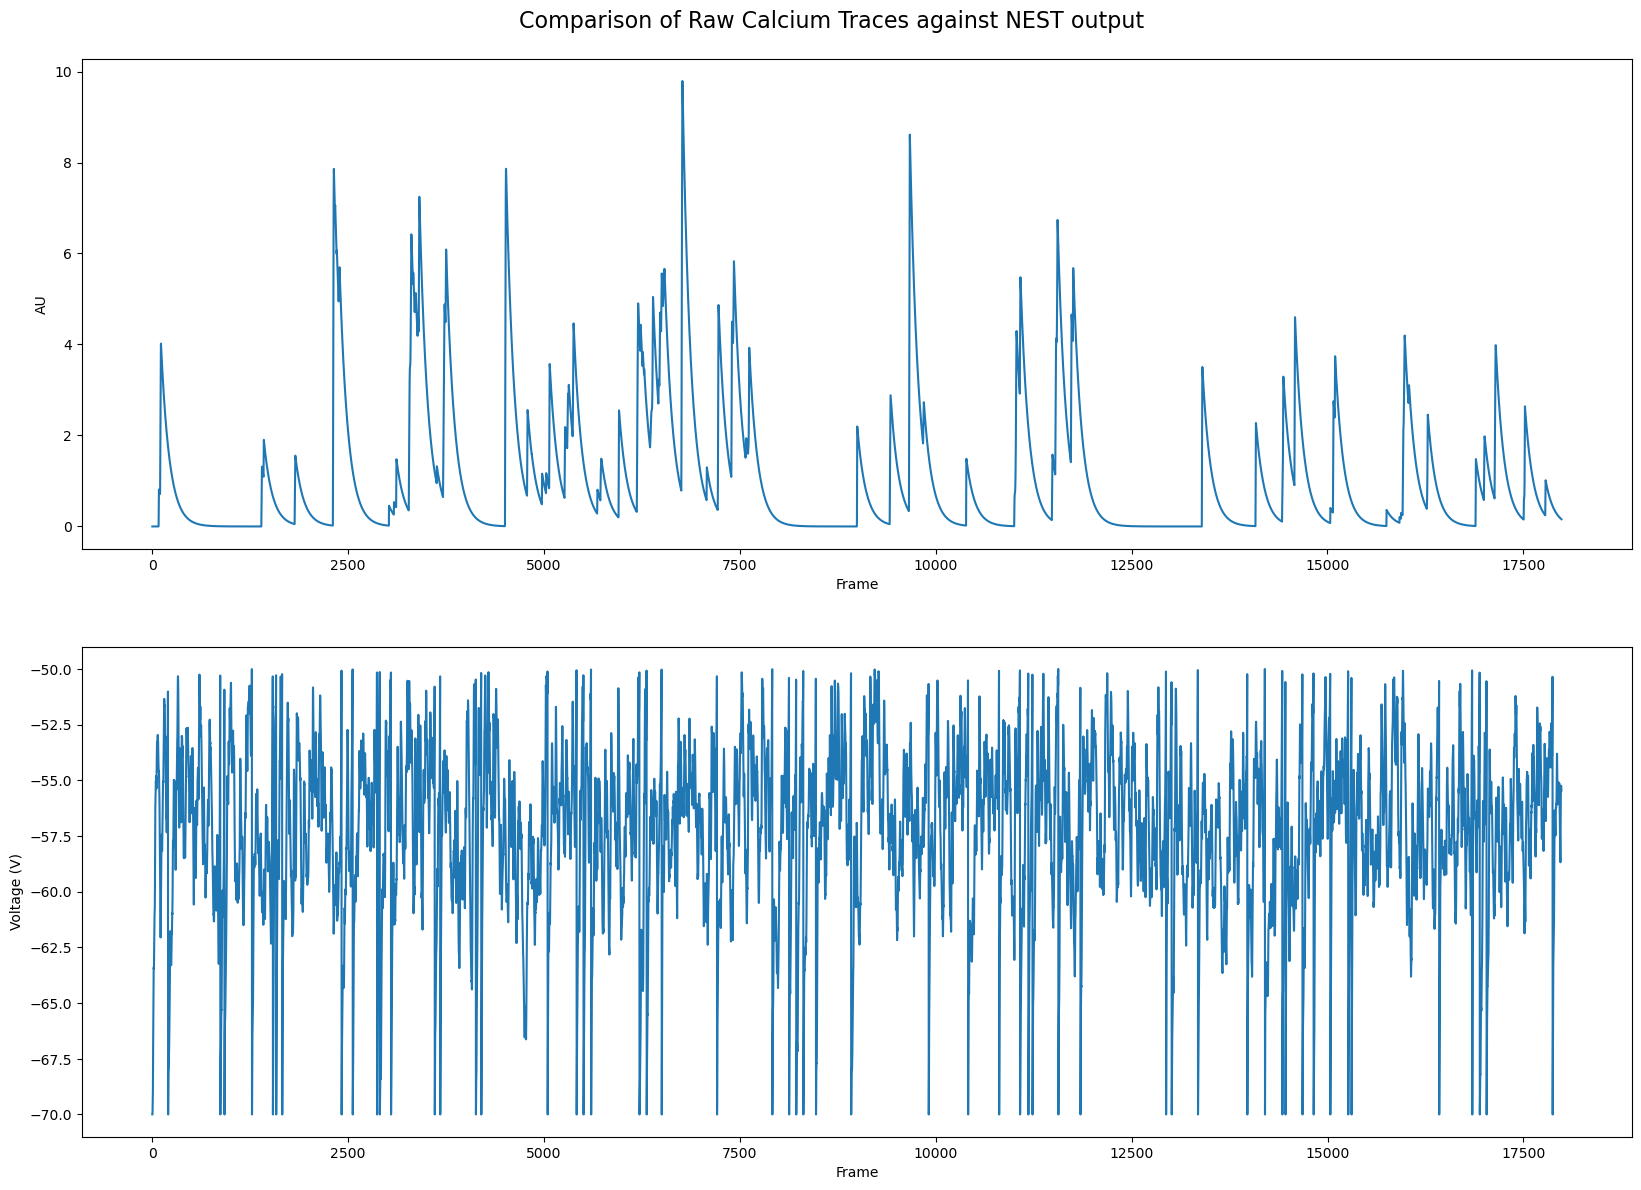

In [3]:
import numpy as np
import nest
import matplotlib.pyplot as plt

from params import pyr_hcamp_deco2012
from scripts import visualizations

calcium_trace_1 = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')[83]

pyr = nest.Create('iaf_psc_alpha', n=1, params=pyr_hcamp_deco2012.params)
external_input = nest.Create('poisson_generator', n=10)
external_input.set(rate=40)

external_parrot = nest.Create('parrot_neuron', n=1)


nest.Connect(external_input, external_parrot)
nest.Connect(external_parrot, pyr, syn_spec={'weight': 90})

Vm_recorder = nest.Create('multimeter')
Vm_recorder.set(record_from=['V_m'])
nest.Connect(Vm_recorder, pyr)

spike_recorder = nest.Create('spike_recorder')
nest.Connect(pyr, spike_recorder)

nest.Simulate(17988)

ts = Vm_recorder.get('events')['times']
vms = Vm_recorder.get('events')['V_m']
fig, axs = plt.subplots(2, 1, figsize=(20, 14))
axs[0].plot(calcium_trace_1)
axs[0].set_ylabel('AU')
axs[0].set_xlabel('Frame')


axs[1].plot(vms)
axs[1].set_ylabel('Voltage (V)')
axs[1].set_xlabel('Frame')

fig.suptitle('Comparison of Raw Calcium Traces against NEST output', y=0.915, fontsize = 16)
plt.savefig('/hpc/mzhu843/modelling/nest/plots/raw_vs_simulation.png')





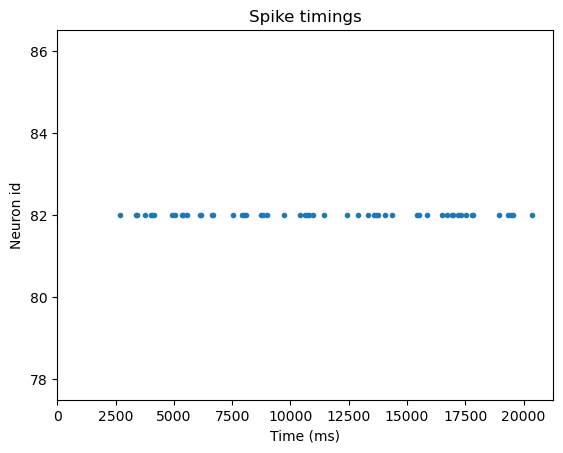

In [4]:
visualizations.plot_spikes_from_device(spike_recorder) 

In [5]:
events = Vm_recorder.get('events')['V_m']
count = 0
for num in events:
    print(num)

-70.0
-70.0
-69.99258238230686
-69.80992492745425
-69.53963741165063
-69.28911000756162
-69.09434688156557
-68.88298886650632
-68.4046520965538
-67.64660175937048
-66.87986085786999
-66.26583699810476
-65.68137036524917
-64.95875682334486
-64.30470372691174
-63.82815827404542
-63.53949063426231
-63.41129829559964
-63.40661838250083
-63.46308868525043
-63.393358777171535
-63.24686045615852
-62.97501133738441
-62.69961406800492
-62.34064740392303
-61.88528674745102
-61.45300456613721
-61.16254903620098
-61.03274824275169
-60.94623967392347
-60.81020970805941
-60.73785106995931
-60.44739592652229
-59.79096040434847
-58.875178598426935
-57.9385588561554
-57.19812516936315
-56.56518646259136
-56.15122254357094
-55.9732071500475
-55.78849078901852
-55.49245504897408
-55.28648295643969
-55.1511899693244
-55.023751869466224
-55.01969529913529
-55.13332496066617
-55.0457622279743
-54.87317343782759
-54.80323760170108
-54.88442442727977
-55.106691769741026
-55.374617617173946
-55.28823017706127


In [6]:
import numpy as np
from scripts import preprocessing
import matplotlib.pyplot as plt

spike_trains = np.load('/hpc/mzhu843/modelling/nest/DATA/processed/spikes/S_3_p.npy')

calcium_traces = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')

calcium, f_maxs = preprocessing.preprocess_calcium_data(calcium_traces, spike_trains, -50, -70, True, True)





